### Importação das bibliotecas iniciais
Para iniciar o trabalho, importamos algumas das bibliotecas que serão úteis no decorrer do algoritmo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

### Carregamento dos dados
Fazemos o carregamento dos dados e a verificação inicial do dataset através do carregamento das primeiras linhas.

In [ ]:
dados = pd.read_csv("heart.csv")
dados.head() 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Podemos também ter uma visão do formato do dataset e de suas informações gerais.

In [ ]:
dados.shape

(918, 12)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Pré-processamento
Nesta etapa, faremos os tratamentos necessários no nosso dataset. Primeiramente, utilizamos o método describe() para verificar como os dados estão distribuídos.

In [ ]:
dados.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Podemos perceber que temos valores zerados para o colesterol, pressão arterial em descanso (RestingBS) e açúcar no sangue em jejum (FastingBS).
No caso da coluna FastingBS, isso não é o problema, já que na verdade os valores dessa coluna se referem à informação binária sobre o valor da taxa de açúcar ser maior ou menor que 120 mg/dL.
Para as outras duas colunas, vamos explorar mais a fundo.

In [ ]:
len(dados[dados['Cholesterol']==0])

172

In [ ]:
print(len(dados[dados['RestingBP']==0]))
dados[dados['RestingBP']==0]

1


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [ ]:
#Excluindo a linha 449
dados.drop(449,inplace = True)

Temos 172 observações zeradas na coluna colesterol, e 1 observação zerada referente ao batimento cardíaco em repouso, que podemos excluir sem problemas. Quanto ao colesterol, vejamos o quanto ele influencia na classificação da doença cardíaca.

Primeiramente transformamos as variáveis categóricas em numéricas, para avaliar sua participação na classificação.

In [ ]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

dados = pd.get_dummies(data = dados,
                         prefix = cat_variables,
                         columns = cat_variables)

Em seguida, podemos plotar o mapa das correlações de cada coluna com a classificação de HeartDisease

<Axes: >

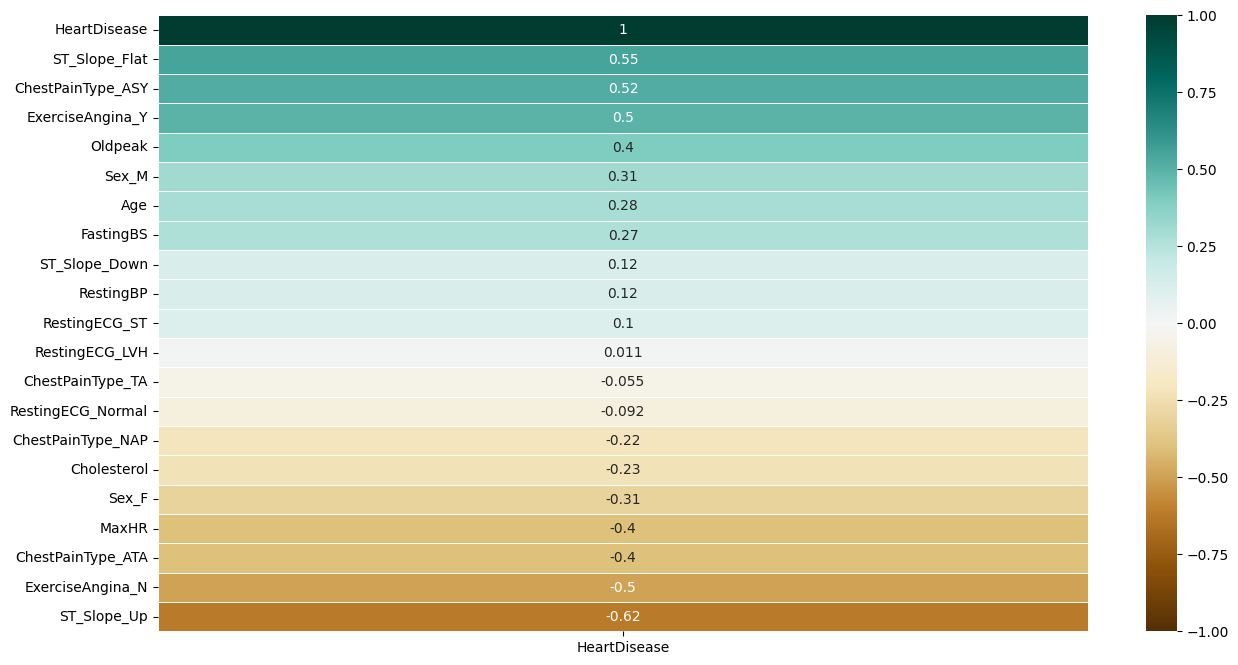

In [ ]:
plt.figure(figsize=(15,8))

sns.heatmap(dados.corr()[['HeartDisease']].sort_values(by='HeartDisease', ascending=False),cmap='BrBG', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=.5,square=False)

Percebemos que o colesterol tem uma correlação negativa com a classificação da presença ou não da doença cardíaca. Nesse caso, podemos excluir esta coluna sem atrapalhar na predição.
Vale também observar que a transformação das variáveis categóricas em numéricas fez com que novas colunas surgissem no dataset.

In [ ]:
dados.drop('Cholesterol',axis=1,inplace=True)
dados.describe()

,Age,RestingBP,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,0.233370,136.789531,0.886696,0.552890,0.210469,0.789531,0.540894,0.188659,0.220284,0.050164,0.205016,0.600872,0.194111,0.595420,0.404580,0.068702,0.500545,0.430752
std,9.437636,17.999749,0.423206,25.467129,1.066960,0.497466,0.407864,0.407864,0.498597,0.391451,0.414664,0.218401,0.403934,0.489986,0.395731,0.491078,0.491078,0.253085,0.500273,0.495452
min,28.000000,80.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,0.000000,120.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,0.000000,138.000000,0.600000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,60.000000,140.000000,0.000000,156.000000,1.500000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A partir do heatmap plotado, pudemos ver o quanto cada feature está relacionada com a classe de classificação. Sendo assim, vamos nos focar nas features com dados originalmente numéricos para explorar a presença de outliers.

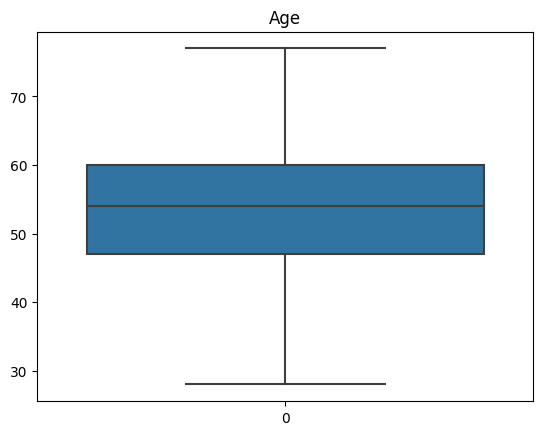

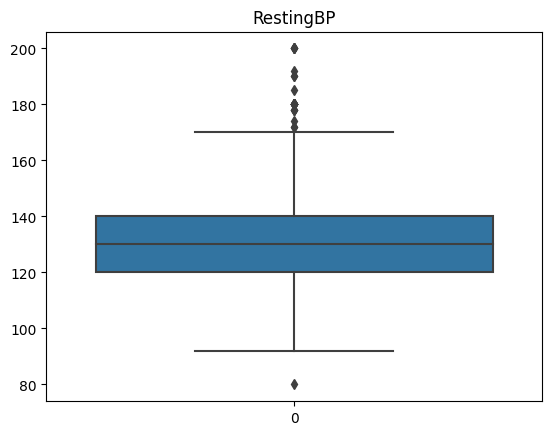

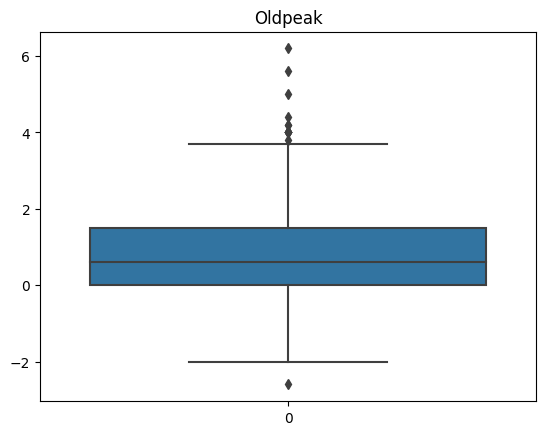

In [ ]:
colunas = dados[['Age', 'RestingBP','Oldpeak']]
for column in colunas:
    sns.boxplot(data = dados[column])
    plt.title(column)
    plt.show()

Percebemos que as colunas Oldpeak e RestingBP possuem outliers. Vamos removê-los.

In [ ]:
outliers = [['RestingBP','Oldpeak']]

# Loop pelas colunas selecionadas removendo outliers
for column in outliers:
    Q1 = dados[column].quantile(0.25)
    Q3 = dados[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = dados[(dados[column] >= lower_bound) & (dados[column] <= upper_bound)]#Dataset contendo as colunas com outliers removidos

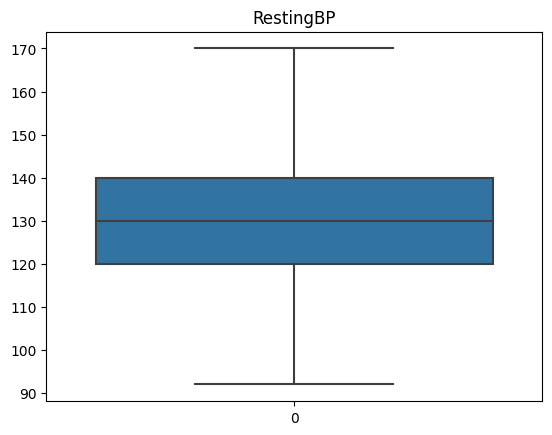

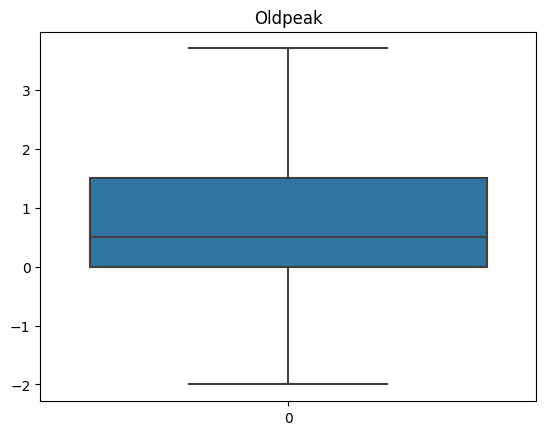

In [ ]:
colunas = df[['RestingBP','Oldpeak']]
for column in colunas:
    sns.boxplot(data = df[column])
    plt.title(column)
    plt.show()

Podemos ver que agora nenhuma das colunas nas quais nos focamos possui outliers. Passaremos então para a modelagem e predição utilizando MLP. Porém, antes é necessário atualizar os valores das novas colunas no dataframe "dados".

In [ ]:
dados['RestingBP'] = df['RestingBP']
dados['Oldpeak'] = df['Oldpeak']
dados

,Age,RestingBP,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,0,172,0.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160.0,0,156,1.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130.0,0,98,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138.0,0,108,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150.0,0,122,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110.0,0,132,1.2,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0
914,68,144.0,1,141,3.4,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0
915,57,130.0,0,115,1.2,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0
916,57,130.0,0,174,0.0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0


Também preencheremos as colunas cujos outliers foram removidos com os valores de média de cada uma das colunas.

In [ ]:
dados['RestingBP'] = dados['RestingBP'].fillna(dados['RestingBP'].mean())
dados['Oldpeak'] = dados['Oldpeak'].fillna(dados['Oldpeak'].mean())

### Separação em treino e teste
Primeiramente, fazemos a reordenação das colunas e, em seguida, a separação do nosso dataset em treino e teste. 
Selecionamos as colunas de interesse que irão compor as features (X) e indicamos qual é o nosso target (y).
Em seguida, fazemos a separação em treino e teste, deixando 30% do dataset para teste e fazendo a estratificação.
Por fim vemos quanto de cada valor temos na porção de treino de y.


In [ ]:
lista_colunas = ['Age', 'RestingBP', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up','HeartDisease']
dados_coracao = dados.reindex(columns = lista_colunas)
dados_coracao.head()

,Age,RestingBP,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140.0,0,172,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0
1,49,160.0,0,156,1.0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1
2,37,130.0,0,98,0.0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0
3,48,138.0,0,108,1.5,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1
4,54,150.0,0,122,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0


In [ ]:
X,y = dados.loc[:,"Age":"ST_Slope_Up"],dados.loc[:,"HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True,stratify = y)
np.bincount(y_train)


array([287, 354])

Para decidir melhor os hiperparâmetros do classificador MLP, plotamos as três variáveis mais significantes na classificação e verificamos a correlação das mesmas com a presença ou não de uma possível doença cardíaca.

In [ ]:
import plotly.express as px
fig = px.scatter_3d(
    dados_coracao, x=dados_coracao['ST_Slope_Flat'], y=dados_coracao['ChestPainType_ASY'], z=dados_coracao['ExerciseAngina_Y'], color=dados_coracao['HeartDisease'],
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

Podemos ver que uma ou duas retas são suficientes para obtermos uma classificação com acurácia satisfatória, já que as diferentes categorias estão bem separadas.

### Pipeline
Abaixo, construímos um pipeline com um normalizador z-score, um redutor de dimensionalidade PCA (configurado com número de componentes igual a 7) e um classificador MLP com 3 camadas ocultas de 2 neurônios, uma taxa de aprendizagem de 0,1 e 1000 iterações

In [ ]:
pipe = Pipeline([
        ('z-score', StandardScaler()),
        ('reduce_dim', PCA(n_components=7)),
        ('classify', MLPClassifier(hidden_layer_sizes=(2,2,2),learning_rate_init = 0.1,random_state=1, max_iter=1000).fit(X_train, y_train))])

### Fit do pipeline
Em seguida, usamos o método fit, que faz com que todas as etapas que definimos no pipeline, sejam seguidas.

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=7)),
                ('classify',
                 MLPClassifier(hidden_layer_sizes=(2, 2, 2),
                               learning_rate_init=0.1, max_iter=1000,
                               random_state=1))])

### Avaliação de acurária relativa ao treino
Utilizando o accuracy score e configurando-o em relação aos dados de treino, podemos ver o desempenho do classificador em relação a esses dados. No caso temos aproximadamente 90% de acurácia do classificador com os dados de teste.

In [ ]:
y_test_pred = pipe.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9021739130434783

### Utilização do Grid search
Para que a definição de hiperparâmetros não seja apenas uma questão de configuração aleatória, utilizaremos o grid search, fazendo com que hajam testes do nosso classificador levando em conta diferentes hiperparâmetros. No caso, vamos ver como podemos melhorar nossa acurácia variando o número de componentes, o número de iterações, o número de neurônios nas camadas escondidas e a taxa de aprendizagem.


In [ ]:
param_grid = {
    'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14],
    'classify__max_iter': [500, 1000, 1500, 2000],
    'classify__hidden_layer_sizes': [2, 4, 8, 16, 32, 64, 128, 256],
    'classify__learning_rate_init': [0.2, 0.5, 0.7, 1]   
}

grid = GridSearchCV(pipe, cv=2, n_jobs=1, param_grid=param_grid, scoring='accuracy')

### Fazendo o fit
Faz-se o fit utilizando os dados de treino previamente definidos e testando o classificador com os diferentes hiperparâmetros.

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('z-score', StandardScaler()),
                                       ('reduce_dim', PCA(n_components=7)),
                                       ('classify',
                                        MLPClassifier(hidden_layer_sizes=(2, 2,
                                                                          2),
                                                      learning_rate_init=0.1,
                                                      max_iter=1000,
                                                      random_state=1))]),
             n_jobs=1,
             param_grid={'classify__hidden_layer_sizes': [2, 4, 8, 16, 32, 64,
                                                          128, 256],
                         'classify__learning_rate_init': [0.2, 0.5, 0.7, 1],
                         'classify__max_iter': [500, 1000, 1500, 2000],
                         'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 14]},
             scoring='accuracy')

### Resultados
Utilizando o best_score e o best_params_ conseguimos ver qual foi o melhor score testando os variados hiperparâmetros e quais foram os valores de hiperparâmetros que proporcionaram esse score.


In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.9328952492211837
{'classify__hidden_layer_sizes': 8, 'classify__learning_rate_init': 0.7, 'classify__max_iter': 500, 'reduce_dim__n_components': 10}


### Classificador com best estimator
A partir daí podemos criar um novo classifcador que utilize os melhores hiperâmetros.

In [ ]:
clf = grid.best_estimator_

### Conclusão
Por fim, podemos ver qual é a acurácia do classificador com os melhores hiperparâmetros.

In [ ]:
y_test_pred = clf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9347826086956522

A matriz confusão segue como podemos ver:

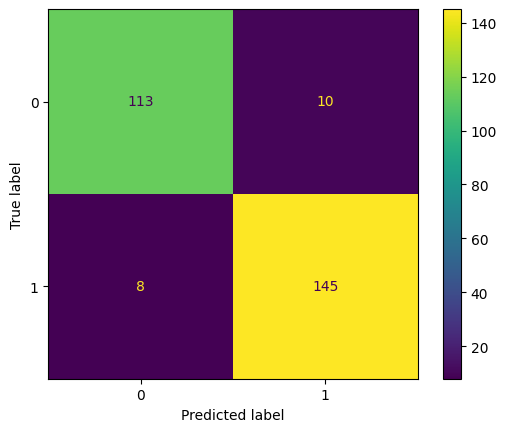

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=clf.classes_)
disp.plot()

Vamos testar a utilização do K-fold para fazer o cross validation:

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

sk_folds = StratifiedKFold(n_splits = 5)
scores = cross_val_score(clf, X, y, cv = sk_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores)) 

Cross Validation Scores:  [0.91847826 0.94565217 0.90710383 0.89617486 0.87431694]
Average CV Score:  0.9083452126395818
Number of CV Scores used in Average:  5
